<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-train,-test,-and-validation-sets" data-toc-modified-id="Prepare-train,-test,-and-validation-sets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare train, test, and validation sets</a></span><ul class="toc-item"><li><span><a href="#Exploratory-data-analysis-(EDA)" data-toc-modified-id="Exploratory-data-analysis-(EDA)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exploratory data analysis (EDA)</a></span></li></ul></li><li><span><a href="#Load-embedding" data-toc-modified-id="Load-embedding-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load embedding</a></span></li><li><span><a href="#Prepare-features-(X)-and-labels-(Y)" data-toc-modified-id="Prepare-features-(X)-and-labels-(Y)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare features (X) and labels (Y)</a></span><ul class="toc-item"><li><span><a href="#Tokenization-and-padding" data-toc-modified-id="Tokenization-and-padding-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Tokenization and padding</a></span></li><li><span><a href="#Creating-an-embedding-matrix" data-toc-modified-id="Creating-an-embedding-matrix-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Creating an embedding matrix</a></span></li><li><span><a href="#Encoding-the-labels" data-toc-modified-id="Encoding-the-labels-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Encoding the labels</a></span></li></ul></li><li><span><a href="#Evaluate-different-models" data-toc-modified-id="Evaluate-different-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluate different models</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#LSTM" data-toc-modified-id="LSTM-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>LSTM</a></span><ul class="toc-item"><li><span><a href="#GloVe" data-toc-modified-id="GloVe-4.0.1.1"><span class="toc-item-num">4.0.1.1&nbsp;&nbsp;</span>GloVe</a></span></li></ul></li><li><span><a href="#Fast-text" data-toc-modified-id="Fast-text-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Fast text</a></span></li><li><span><a href="#GRU" data-toc-modified-id="GRU-4.0.3"><span class="toc-item-num">4.0.3&nbsp;&nbsp;</span>GRU</a></span></li><li><span><a href="#GloVe" data-toc-modified-id="GloVe-4.0.4"><span class="toc-item-num">4.0.4&nbsp;&nbsp;</span>GloVe</a></span></li><li><span><a href="#Fast-text" data-toc-modified-id="Fast-text-4.0.5"><span class="toc-item-num">4.0.5&nbsp;&nbsp;</span>Fast text</a></span></li><li><span><a href="#Character-level-CNN" data-toc-modified-id="Character-level-CNN-4.0.6"><span class="toc-item-num">4.0.6&nbsp;&nbsp;</span>Character-level CNN</a></span><ul class="toc-item"><li><span><a href="#GloVe" data-toc-modified-id="GloVe-4.0.6.1"><span class="toc-item-num">4.0.6.1&nbsp;&nbsp;</span>GloVe</a></span></li><li><span><a href="#Fast-text" data-toc-modified-id="Fast-text-4.0.6.2"><span class="toc-item-num">4.0.6.2&nbsp;&nbsp;</span>Fast text</a></span></li></ul></li></ul></li><li><span><a href="#Transformer-(TODO)" data-toc-modified-id="Transformer-(TODO)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Transformer (TODO)</a></span></li></ul></li><li><span><a href="#Prepare-the-prediction" data-toc-modified-id="Prepare-the-prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prepare the prediction</a></span></li></ul></div>

 
Which Novel Do I Belong To?

In this task, you are expected to learn a Machine Learning model that classifies a given line as belonging to one of the following 12 novels:

0: alice_in_wonderland
1: dracula
2: dubliners
3: great_expectations
4: hard_times
5: huckleberry_finn
6: les_miserable
7: moby_dick
8: oliver_twist
9: peter_pan
10: talw_of_two_cities
11: tom_sawyer


Description:

You are provided with a zip file (offline_challenge.zip) containing three text files - xtrain.txt, ytrain.txt, xtest.txt. Each line in xtrain.txt and xtest.txt comes from a different novel. The data has been obfuscated, however the patterns in them are preserved. The novel ids corresponding to xtrain.txt are specified in ytrain.txt. You can use these labels to train a Machine Learning model (Deep Learning preferred).

With the learned model, predict the novel ids of the lines in xtest.txt (one prediction per line). As part of your submission, include

a) your predictions (in the same format as ytrain.txt)
b) Expected accuracy on the test set
c) the source code for training and prediction (< 10MB)
d) a brief description of your method (optional)


In [196]:
from matplotlib import pyplot


import numpy as np # linear algebra
from numpy import genfromtxt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

import keras
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling1D, Conv1D, GlobalMaxPool1D, Bidirectional
from keras.layers import LSTM, Lambda, Bidirectional, concatenate, BatchNormalization, Embedding
from keras.layers import Reshape, RepeatVector
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
import tensorflow as tf
import keras.backend as K

import IPython
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot




In [2]:
path = '../offline_challenge/'

x_train_file = path + 'xtrain_obfuscated.txt'
y_train_file = path + 'ytrain.txt'
x_test_file = path + 'xtest_obfuscated.txt'


In [53]:
with open(x_train_file) as f:
    xtrain_obfuscated = f.read().strip().lower().split('\n')
    
with open(y_train_file) as f:
    ytrain = f.read().strip().split('\n')
for i in range(len(ytrain)):
    ytrain[i] = int(ytrain[i])

with open(x_test_file) as f:
    xtest_obfuscated = f.read().strip().lower().split('\n')
    
    

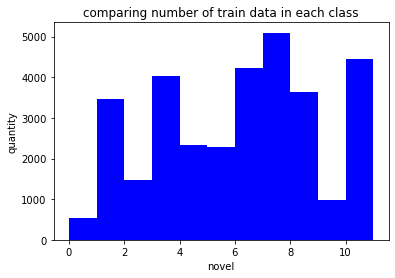

"\nThe data set appears to be imbalanced as class '0' is represented by very few data points as compared\nto class 7 or class 6\n\n"

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.hist(ytrain, bins=range(min(ytrain), max(ytrain) + 1, 1),
              alpha=1, color="blue")
plt.xlabel("novel")
plt.ylabel("quantity")
plt.title("comparing number of train data in each class")
plt.show()
'''
The data set appears to be imbalanced as class '0' is represented by very few data points as compared
to class 7 or class 6

'''



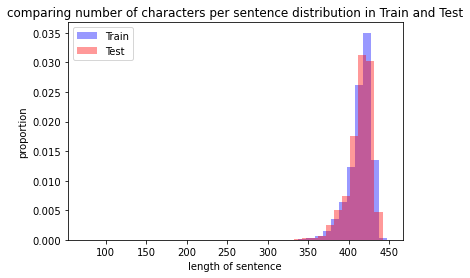

In [57]:
# Length of train and test data distribution

sentence_lengths_train = [ len(sent) for sent in xtrain_obfuscated]
sentence_lengths_test = [ len(sent) for sent in xtest_obfuscated]

plt.hist(sentence_lengths_train, bins=range(min(sentence_lengths_train), max(sentence_lengths_train) + 1, 10), 
              alpha=0.4, color="blue", density=True)
plt.hist(sentence_lengths_test, bins=range(min(sentence_lengths_test), max(sentence_lengths_test) + 1, 10),
              alpha=0.4, color="red", density=True)
labels = ['Train',"Test"]
plt.legend(labels)
plt.xlabel("length of sentence")
plt.ylabel("proportion")
plt.title("comparing number of characters per sentence distribution in Train and Test")
plt.show()


In [75]:
with open(x_train_file) as f:
    x_train = f.read().split('\n')
x_train = x_train[:-1]

with open(y_train_file) as f:
    y_train = f.read().split('\n')
y_train = [int(y) for y in y_train if y.isdigit()] 


In [79]:
max_char = 26
max_sent_len = 0
for sent in x_train:
    max_sent_len = max(max_sent_len, len(sent))




In [93]:
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)


In [94]:
#One hot encoding for labels
y_train = OneHotEncoder(sparse=False).fit_transform(y_train)



In [ ]:
# One hot feature generation
# MaxLen = 452. 
# Other sentences are 0 padded
x_train_onehot = []

for i in range(len(x_train)):
    temp = np.zeros((max_sent_len, max_char))
    for j in range(len(x_train[i])):
        temp[j][ord(x_train[i][j]) - ord('a')] = 1
    x_train_onehot.append(temp)
    
x_train_onehot = np.asarray(x_train_onehot)

x_train_onehot = x_train_onehot.reshape((x_train_onehot.shape[0], 
                                         x_train_onehot.shape[1], 
                                         x_train_onehot.shape[2], 
                                         1))



97

## Prepare train, test, and validation sets


In [154]:
with open(x_train_file) as f:
    x_train_all = f.read().strip().lower().split('\n')
    
with open(y_train_file) as f:
    y_train = f.read().strip().split('\n')
for i in range(len(ytrain)):
    y_train[i] = int(ytrain[i])

with open(x_test_file) as f:
    x_test = f.read().strip().lower().split('\n')
    
    

### Exploratory data analysis (EDA)


In [155]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train, test_size=0.2, random_state=42)


## Load embedding

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html



- GloVe
- Fast text


In [217]:
def get_embedding(embedding_file):
    embedding_dict = {}
    with open(embedding_file) as f:
        for line in tqdm(f):
            values = line.split()
            word = values[0]
            embedding_dict[word] = np.asarray(values[1:], dtype='float32')
    return embedding_dict



In [218]:
glove_path = '../glove.6B.300d.txt'
#glove_path = '../glove.840B.300d.txt'
glove_embedding = {}

#fasttext_path = '../wiki-news-300d-1M.vec'
fasttext_path = '../crawl-300d-2M.vec'
fasttext_embedding = {}

glove_embedding = get_embedding(glove_path)
fasttext_embedding = get_embedding(fasttext_path)


400000it [00:35, 11409.46it/s]
1999996it [02:52, 11590.40it/s]


## Prepare features (X) and labels (Y)



### Tokenization and padding


In [219]:

max_features = None
token = text.Tokenizer(num_words=max_features, char_level=True)

token.fit_on_texts(list(x_train_all) + list(x_test))
x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)
x_test_seq = token.texts_to_sequences(x_test)

# zero pad the sequences
#max_sent_len = 200
max_sent_len = max([len(sent) for sent in x_train_all])
x_train_seq = sequence.pad_sequences(x_train_seq, maxlen=max_sent_len)
x_valid_seq = sequence.pad_sequences(x_valid_seq, maxlen=max_sent_len)
x_test_seq = sequence.pad_sequences(x_test_seq, maxlen=max_sent_len)

word_index = token.word_index


In [220]:
print(len(x_train_seq))
print(len(x_valid_seq))
print(len(x_test_seq))

print(len(x_train_seq[0]))

print(x_train_seq[0])
print(word_index)


26010
6503
3000
452
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 15 12  4  9  5 14 12 17  1  2 13 17 15 12  8  7
  6  5  8  7 15 12  3  4 13  4  4  9 10  3 21 10  1  2  8  7 11  3 13  4
  1  2  9 25 13 17  8  7  4  9 10  3  1  2 10  3  1  6  4  9  3  4  1  2
  1  6  8  7  6 16  1  2  9  7  9  7  3  4 19 20  1  2  8  7 11  3 22 21
 12 17  1  2  1  2 16 11  1  6 13  4  8  7 12 16 15 18  8  7  6  5  1  2
  1  6  5 14  8  7  6  5  6 16  1  2  4  9  3  4  1  2  8  7  6  5  8  7
 19 20  1  2 11  3 21 10  3  4 11  3 19 20  1  2 13 17 13  4  8  7 11  3
 21 10  5 14 10  3 21 10  1  2  6 16  4  9  3  4  1  6  3  4  5 14 19 20
  1  2  8  7 11  3  1  6  1  2 13  4 15 12  6  5  5 14 19 20 10  3  1  6
  1  2 13  4  8  7 15 11  8  7  1  2 15 12  8  7  1  6 21 10  5 14  6  5
  1  6 13  4  3  4 15 12  1  2  6  5  8  7 11  3  1  2 15 12  8  7  4  9
  6  5 12 16  1  6  1  2  1  6  3  4 13  4  6  5  5 14 17 18 22 21  1  2
 16 11 13  4  6  5 13 25  1  2 

### Creating an embedding matrix


In [221]:
embedding_len=300


In [222]:
# embedding matrix
def get_embedding_matrix(embedding, 
                         word_index, 
                         embedding_len=300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_len))
    for word, i in tqdm(word_index.items()):
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
        
    

In [223]:

fasttext_embedding_matrix = get_embedding_matrix(embedding=fasttext_embedding,
                                                 word_index=word_index,
                                                 embedding_len=embedding_len,
                                                )


100%|██████████| 26/26 [00:00<00:00, 11339.49it/s]


In [224]:
glove_embedding_matrix = get_embedding_matrix(embedding=glove_embedding,
                                              word_index=word_index,
                                              embedding_len=embedding_len,
                                             )


100%|██████████| 26/26 [00:00<00:00, 1621.88it/s]


### Encoding the labels


In [225]:

y_train_en = np_utils.to_categorical((y_train))
y_valid_en = np_utils.to_categorical((y_valid))



In [226]:
def plot_confusion_matrix(y_test, y_pred):
    confusion_mtx = confusion_matrix(y_test, y_pred) 
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    return

def plot_learning_curves(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')

    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.show()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #pyplot.savefig(filename + '_plot.png')
    #pyplot.close()
    #image = imread(filename + '_plot.png')
    #pyplot.figure(figsize=(10, 25))
    #pyplot.imshow(image)
    return 


## Evaluate different models



In [227]:
n_classes = 12
batch_size = 32
epochs = 500

model_dict = {}


#### LSTM

##### GloVe

In [210]:
"""
model = Sequential()

model.add(Embedding(len(word_index) + 1,
                    embedding_len,
                    weights=[glove_embedding_matrix],
                    input_length=max_sent_len,
                    trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=0, 
                    validation_data=(x_valid_seq, y_valid_en),
                    callbacks=[earlystop],
                   )

plot_learning_curves(history)

model_dict['lstm_glove'] = model

"""

"\nmodel = Sequential()\n\nmodel.add(Embedding(len(word_index) + 1,\n                    embedding_len,\n                    weights=[glove_embedding_matrix],\n                    input_length=max_sent_len,\n                    trainable=False))\nmodel.add(SpatialDropout1D(0.3))\nmodel.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))\nmodel.add(Dense(64, activation='relu'))\nmodel.add(Dropout(0.3))\n#model.add(Dense(128, activation='relu'))\n#model.add(Dropout(0.3))\nmodel.add(Dense(n_classes))\nmodel.add(Activation('softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\n\nearlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')\n\nhistory = model.fit(x=x_train_seq, \n                    y=y_train_en, \n                    batch_size=batch_size, \n                    epochs=epochs, \n                    verbose=0, \n                    validation_data=(x_valid_seq, y_valid_en),\n                    c

#### Fast text


In [211]:
"""
model = Sequential()

model.add(Embedding(len(word_index) + 1,
                    embedding_len,
                    weights=[fasttext_embedding_matrix],
                    input_length=max_sent_len,
                    trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=0, 
                    validation_data=(x_valid_seq, y_valid_en),
                    callbacks=[earlystop],
                   )

plot_learning_curves(history)

model_dict['lstm_fasttext'] = model
"""


"\nmodel = Sequential()\n\nmodel.add(Embedding(len(word_index) + 1,\n                    embedding_len,\n                    weights=[fasttext_embedding_matrix],\n                    input_length=max_sent_len,\n                    trainable=False))\nmodel.add(SpatialDropout1D(0.3))\nmodel.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))\nmodel.add(Dense(64, activation='relu'))\nmodel.add(Dropout(0.3))\n#model.add(Dense(128, activation='relu'))\n#model.add(Dropout(0.3))\nmodel.add(Dense(n_classes))\nmodel.add(Activation('softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\n\nearlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')\n\nhistory = model.fit(x=x_train_seq, \n                    y=y_train_en, \n                    batch_size=batch_size, \n                    epochs=epochs, \n                    verbose=0, \n                    validation_data=(x_valid_seq, y_valid_en),\n                  

#### GRU

#### GloVe


In [ ]:

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     embedding_len,
                     weights=[embedding_matrix],
                     input_length=max_sent_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=0, 
                    validation_data=(x_valid_seq, y_valid_en),
                    callbacks=[earlystop],
                   )
plot_learning_curves(history)

model_dict['gru_glove'] = model


#### Fast text


In [ ]:

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     embedding_len,
                     weights=[embedding_matrix],
                     input_length=max_sent_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=0, 
                    validation_data=(x_valid_seq, y_valid_en),
                    callbacks=[earlystop],
                   )

plot_learning_curves(history)

model_dict['gru_fasttext'] = model


#### Character-level CNN

https://www.kaggle.com/kmader/character-level-cnn-classification-with-dilations

https://machinelearningmastery.com/best-practices-document-classification-deep-learning/



##### GloVe


In [208]:
model = Sequential()

model.add(Embedding(len(word_index) + 1,
                     embedding_len,
                     weights=[glove_embedding_matrix],
                     input_length=max_sent_len,
                     trainable=False))
model.add(Dropout(0.3))

# add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(64,
                 5,
                 activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128,
                 5,
                 activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(256,
                 5,
                 activation='relu'))
model.add(MaxPooling1D(3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(x_valid_seq, y_valid_en),
                    callbacks=[earlystop],
                   )

plot_learning_curves(history)

model_dict['1dcnn_glove'] = model



Epoch 1/100
1626/1626 [==============================] - 45s 28ms/step - loss: 2.3421 - acc: 0.1564 - val_loss: 2.2663 - val_acc: 0.1810
Epoch 2/100
1626/1626 [==============================] - 47s 29ms/step - loss: 2.2132 - acc: 0.2176 - val_loss: 2.1493 - val_acc: 0.2425
Epoch 3/100
1626/1626 [==============================] - 44s 27ms/step - loss: 2.1136 - acc: 0.2596 - val_loss: 2.0053 - val_acc: 0.2697
Epoch 4/100
1626/1626 [==============================] - 43s 27ms/step - loss: 1.9787 - acc: 0.3014 - val_loss: 1.9365 - val_acc: 0.3068
Epoch 5/100
1626/1626 [==============================] - 44s 27ms/step - loss: 1.8790 - acc: 0.3389 - val_loss: 1.8272 - val_acc: 0.3549
Epoch 6/100
1626/1626 [==============================] - 39s 24ms/step - loss: 1.8136 - acc: 0.3617 - val_loss: 1.8250 - val_acc: 0.3686
Epoch 7/100
1626/1626 [==============================] - 42s 26ms/step - loss: 1.8024 - acc: 0.3680 - val_loss: 1.7611 - val_acc: 0.3704
Epoch 8/100
1626/1626 [==================

##### Fast text


In [ ]:
model = Sequential()

model.add(Embedding(len(word_index) + 1,
                     embedding_len,
                     weights=[fasttext_embedding_matrix],
                     input_length=max_sent_len,
                     trainable=False))
model.add(Dropout(0.3))

# add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(64,
                 5,
                 activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128,
                 5,
                 activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(256,
                 5,
                 activation='relu'))
model.add(MaxPooling1D(3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(x=x_train_seq, 
                    y=y_train_en, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(x_valid_seq, y_valid_en),
                    callbacks=[earlystop],
                   )


plot_learning_curves(history)

model_dict['1dcnn_fasttext'] = model


Epoch 1/500
286/813 [=========>....................] - ETA: 48s - loss: 2.3618 - acc: 0.1547

### Transformer (TODO)


https://atheros.ai/blog/text-classification-with-transformers-in-tensorflow-2

https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert



## Prepare the prediction
